# Sparkify Project 

Please see also my blog post on [Kaggle](https://www.kaggle.com/chriskue/sparkify-user-churn-prediction).

## Overview

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.


## Import the relevant libraries

In [1]:
# import relevant libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import time
from functools import reduce

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics

%matplotlib inline

# Load and Explore the Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Load the data

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

In [3]:
# read the mini-database file
path = "./data/mini_sparkify_event_data.json"
df = spark.read.json(path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

### Exploring

In [4]:
# show the schema of the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# number of records and columns in the dataset
print((df.count(), len(df.columns)))

(286500, 18)


In [6]:
# show the first 5 rows in the dataset
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [7]:
# get further informations of all columns
for col in df.columns:
    df.describe([col]).show()
    df.select([col]).distinct().show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logg

+-------------+
|           ts|
+-------------+
|1538360520000|
|1538368903000|
|1538380099000|
|1538380879000|
|1538390386000|
|1538390440000|
|1538399222000|
|1538402692000|
|1538405492000|
|1538411816000|
|1538420258000|
|1538422643000|
|1538423103000|
|1538428266000|
|1538433192000|
|1538435390000|
|1538439836000|
|1538453678000|
|1538471202000|
|1538494626000|
+-------------+
only showing top 20 rows

+-------+--------------------+
|summary|           userAgent|
+-------+--------------------+
|  count|              278154|
|   mean|                null|
| stddev|                null|
|    min|"Mozilla/5.0 (Mac...|
|    max|Mozilla/5.0 (comp...|
+-------+--------------------+

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.

#### Summary:  
The raw data set consists of 286.500 records with the following features/ informations and data type:

| FEATURE | DESCRIPTION | DATA TYPE | 
|:---|:---|:---|
|**userId** |  Unique User-ID   | object/ string 
|**userAgent** |  Browser and operating system  | object/ string
|**ts**| Time stamp for the user event  | int64/ long
|**sessionId** | Unique user session id  | int64/ long
|**registration**|  Registation date of the user  | float64/ long
|**auth** | Authentication of the user   | object/ string
|**page** | User action in this session   |  object/ string
| | |
|**artist** | Name of the artist  | object/ string
|**song** | Title of the song   | object/ string
|**length**|  Length of the song   | float64/ double
| | | 
|**firstName**|  First name of the user   | object/ string
|**lastName** | Last name of the user   | object/ string
|**gender** | Gender of the user   | object/ string
|**location** | Location of the user  | object/ string
|**level**|  Accout type of the user (payment or free)   | object/ string
| | | 
|**status** | HTTP response status codes  | int64/ long
|**method** | HTTP Method         |    object/ string
|**itemInSession** |  All items in one session   | int64/ long


# Exploratory Data Analysis

### Cleaning
Cleaning the data for further analysis and store the cleaned dataset in `df_clean`

In [8]:
# count the value of missing values in every column
for col in df.columns:
    print(col,  df.filter((df[col].isNull()) | (df[col] == "")).count())

artist 58392
auth 0
firstName 8346
gender 8346
itemInSession 0
lastName 8346
length 58392
level 0
location 8346
method 0
page 0
registration 8346
sessionId 0
song 58392
status 0
ts 0
userAgent 8346
userId 8346


In [9]:
# remove empty values from feature userId
df_clean = df.dropna(how = 'any', subset = ['userId'])
df_clean = df_clean.filter(df_clean['userId'] != '')
df_clean.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [10]:
# number of records in the cleaned dataset
df_clean.count()

278154

### Update
Update and enhance the data for further analysis


- **ts**: Convert the time stamp into more readable format   
- **registration**:  Convert the registration time into more readable format   

In [11]:
# transforming the ts and registation time format
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_clean = df_clean.withColumn('event_time', get_date('ts'))
df_clean = df_clean.withColumn('registration_time', get_date('registration'))
df_clean.select("event_time").distinct().show(5)

+-------------------+
|         event_time|
+-------------------+
|2018-10-01 09:38:43|
|2018-10-01 11:26:48|
|2018-10-01 15:10:18|
|2018-10-01 16:07:52|
|2018-10-01 16:24:20|
+-------------------+
only showing top 5 rows



In [12]:
# time range in the data set   
print(df_clean.agg({"event_time": "min"}).collect()[0][0])
print(df_clean.agg({"event_time": "max"}).collect()[0][0])

2018-10-01 02:01:57
2018-12-03 02:11:16


- **day_of_month:** Get the day of month

In [13]:
# get the day opf month of the timeseries
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_clean = df_clean.withColumn('day_of_month', get_day('ts'))
df_clean.select('day_of_month').show(5)

+------------+
|day_of_month|
+------------+
|           1|
|           1|
|           1|
|           1|
|           1|
+------------+
only showing top 5 rows



- **userAgent**: Extract the operating system into a new feature

In [14]:
# extract Operating System
map = {'Compatible': 'Windows', 'Ipad': 'iPad', 'Iphone': 'iPhone', 'Macintosh': 'Mac',  
       'Windows nt 5.1': 'Windows', 'Windows nt 6.0': 'Windows', 'Windows nt 6.1': 'Windows', 
       'Windows nt 6.2': 'Windows',  'Windows nt 6.3': 'Windows', 'X11': 'Linux'}

get_operating_sys = udf(lambda x: map[re.findall('\(([^\)]*)\)', x)[0].split(';')[0].capitalize()])
df_clean = df_clean.withColumn("operating_system", get_operating_sys(df_clean.userAgent))
df_clean.select("operating_system").distinct().show()

+----------------+
|operating_system|
+----------------+
|            iPad|
|          iPhone|
|           Linux|
|             Mac|
|         Windows|
+----------------+



- **location**:  Extract the state from the location as a new feature

In [15]:
# extract state from location
get_location = udf(lambda x:x[-2:])
df_clean = df_clean.withColumn("location_state", get_location(df_clean.location))
df_clean.select("location_state").distinct().show(5)

+--------------+
|location_state|
+--------------+
|            AZ|
|            SC|
|            LA|
|            NJ|
|            OR|
+--------------+
only showing top 5 rows



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [16]:
# show the content of "page"
df_clean.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [17]:
# downgrade
downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_clean = df_clean.withColumn('downgrade_event', downgrade_event("page"))
df_clean = df_clean.withColumn('downgrade', max('downgrade_event').over(Window.partitionBy('userId')))

In [18]:
# churn
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_clean = df_clean.withColumn('churn_event', churn_event('page'))
df_clean = df_clean.withColumn('churn', max('churn_event').over(Window.partitionBy('userId')))

### Explore Data
*Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.*

#### Number of users who cancelled 

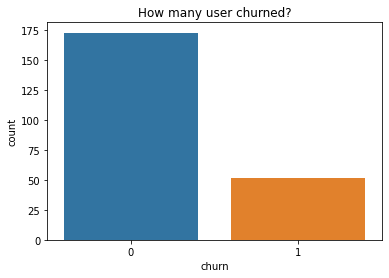

In [19]:
num_churn = df_clean.dropDuplicates(['userId', 'churn']).groupby(['churn']).count().toPandas()

ax = sns.barplot(x='churn', y='count', data=num_churn);
plt.xlabel('churn')
plt.ylabel('count')
plt.title('How many user churned?');

52 users cancelled.

#### Number of users who cancelled or downgraded by gender 

c:\users\user\documents\python36\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


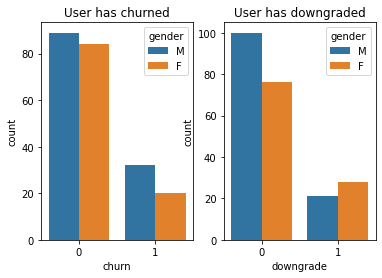

In [20]:
# churn and downgrade pattern between genders
churn_gender = df_clean.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().sort('churn').toPandas()
downgrade_gender = df_clean.dropDuplicates(['userId', 'gender']).groupby(['downgrade', 'gender']).count().sort('downgrade').toPandas()

fig, (ax1, ax2) = plt.subplots(1,2)

sns.barplot(x='churn', y='count', hue='gender', data=churn_gender, ax=ax1) 
ax1.set_xlabel('churn')
ax1.set_ylabel('count')
ax1.legend(title='gender', loc='best')
ax1.set_title('User has churned')

sns.barplot(x='downgrade', y='count', hue='gender', data=downgrade_gender, ax=ax2)
ax2.set_xlabel('downgrade')
ax2.set_ylabel('count')
ax2.legend(title='gender', loc='best')
ax2.set_title('User has downgraded')

fig.show();

#### What account (level) does the user have?

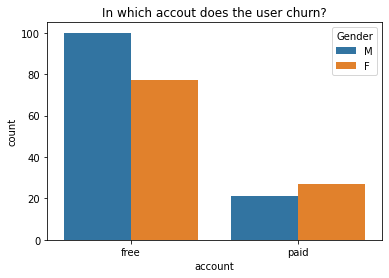

In [21]:
# level (account) of the user
account_churn = df_clean.dropDuplicates(['userId', 'gender']).groupby(['gender', 'level']).count().toPandas()

ax = sns.barplot(x='level', y='count',hue='gender', data=account_churn);
plt.xlabel('account')
plt.ylabel('count')
plt.title('In which accout does the user churn?')
plt.legend(title='Gender', loc='best');

#### After how many days does the user churn?

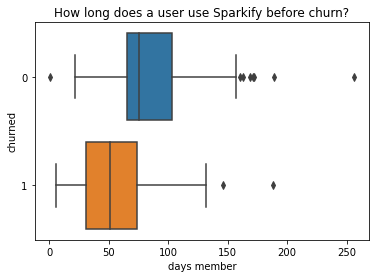

In [22]:
# lifetime (membership) of the users
lifetime = df_clean.select('userId','registration','ts','churn')
lifetime = lifetime.withColumn('lifetime',(df_clean.ts - df_clean.registration)/(1000*3600*24)).groupBy('userId','churn').agg({'lifetime':'max'})
lifetime = lifetime.withColumnRenamed('max(lifetime)','lifetime').select('userId', 'churn', 'lifetime').toPandas()

ax = sns.boxplot(x='lifetime', y='churn', data=lifetime, orient='h');
plt.xlabel('days member');
plt.ylabel('churned');
plt.title('How long does a user use Sparkify before churn?');

#### Is there a diffenece in the location of users who churn?

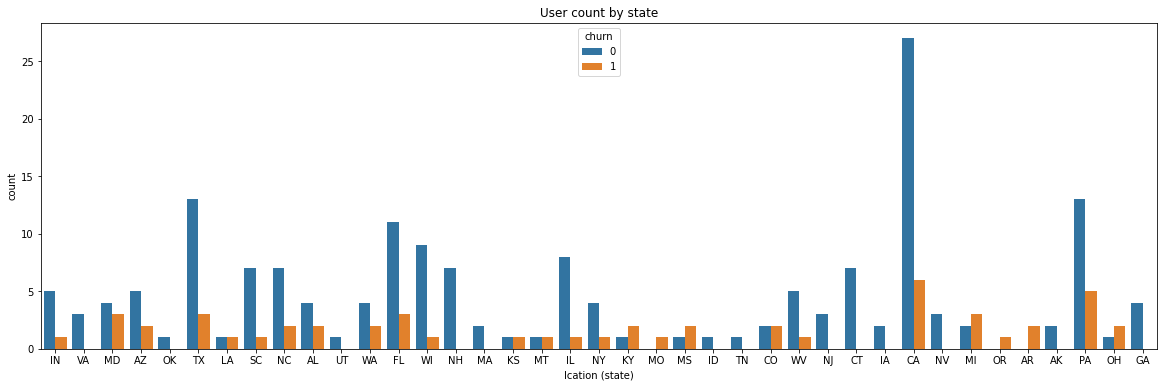

In [23]:
# locations (state) of the users
location_state = df_clean.dropDuplicates(['userId', 'location_state']).groupby(['location_state', 'churn']).count().toPandas()

fig = plt.figure(figsize=(20, 6))

ax = sns.barplot(x='location_state', y='count', hue='churn', data=location_state);
plt.xlabel('lcation (state)')
plt.ylabel('count')
plt.title('User count by state');
plt.legend(title='churn', loc='best');

#### What action does the user do - difference between churn and non churn

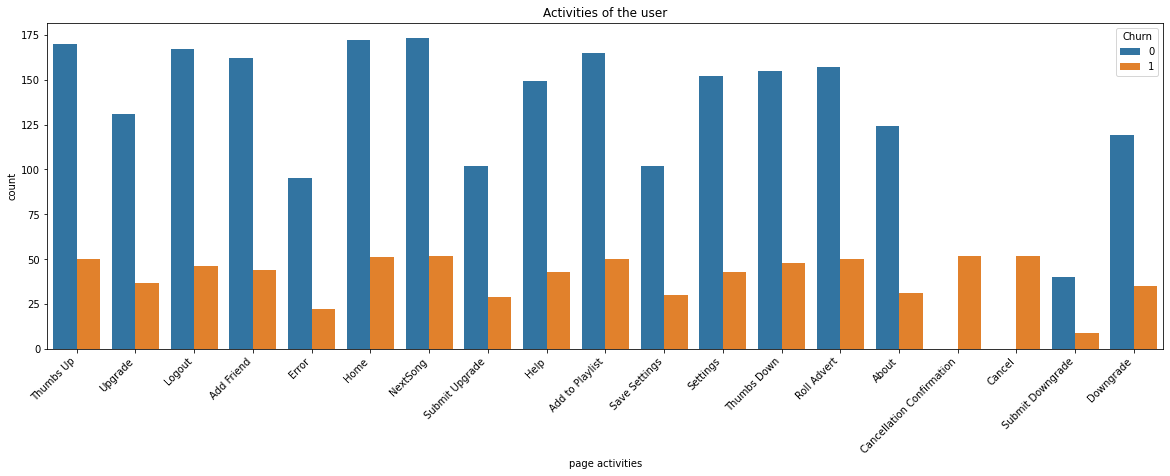

In [24]:
# page actions of the users
page_churn = df_clean.dropDuplicates(['userId', 'page']).groupby(['page', 'churn']).count().toPandas()

fig = plt.figure(figsize=(20, 6))

ax = sns.barplot(x='page', y='count',hue='churn', data=page_churn)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('page activities')
plt.ylabel('count')
plt.title('Activities of the user')
plt.legend(title='Churn', loc='best');

#### Is there a diffence in the operating system?

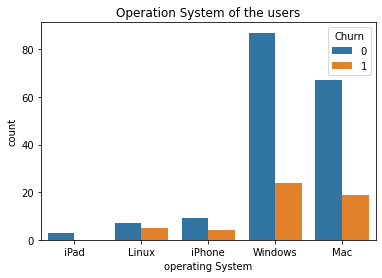

In [25]:
# churn by operationg system
os_churn = df_clean.dropDuplicates(['userId', 'operating_system']).groupby(['churn', 'operating_system']).count().toPandas()

ax = sns.barplot(x='operating_system', y='count',hue='churn', data=os_churn);
plt.xlabel('operating System')
plt.ylabel('count')
plt.title('Operation System of the users')
plt.legend(title='Churn', loc='best');

#### How long do users listen to music?

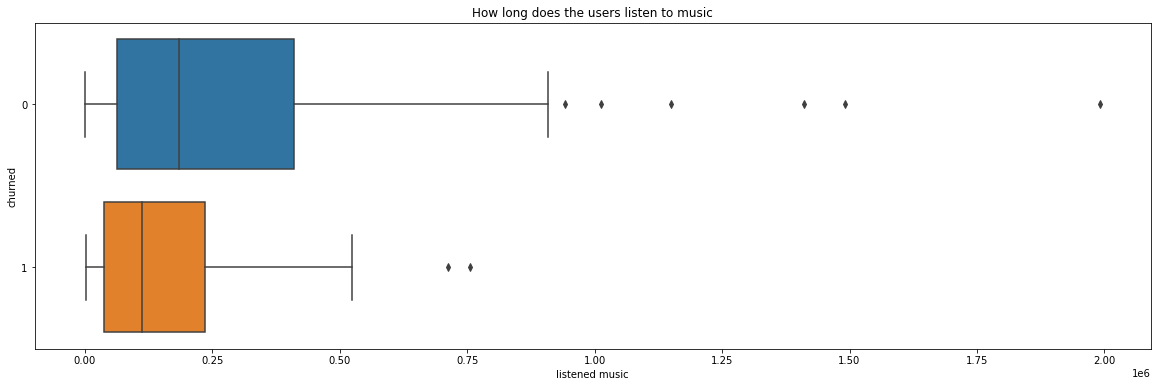

In [26]:
# sum of listened music of the users
sum_listened = df_clean.select('userID','length','churn').groupby(['userID','churn']).sum().withColumnRenamed('sum(length)', 'listen_time').toPandas()

fig = plt.figure(figsize=(20, 6))

ax = sns.boxplot(x='listen_time', y='churn', data=sum_listened, orient='h');
plt.xlabel('listened music');
plt.ylabel('churned');
plt.title('How long does the users listen to music');

#### Is there a difference in the days?

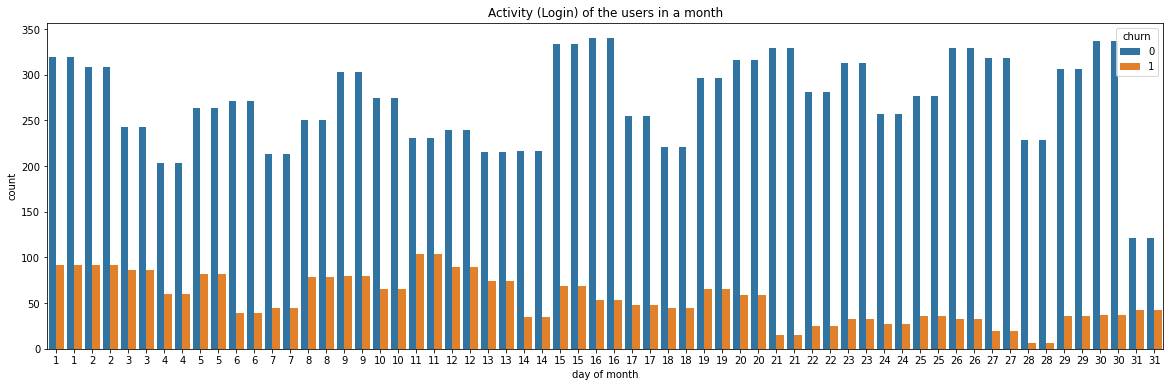

In [27]:
# difference in the day - by page "Home"
day_home = df_clean.filter(df_clean.page == 'Home').groupby(['churn', 'day_of_month']).count().orderBy(df_clean.day_of_month.cast('int')).toPandas()

fig = plt.figure(figsize=(20, 6))

ax = sns.barplot(x='day_of_month', y='count', hue='churn', data=day_home, order=day_home.day_of_month);
plt.xlabel('day of month');
plt.ylabel('count');
plt.title('Activity (Login) of the users in a month');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### In the following i will create a Dataframe with the following informations :   

| FEATURE | Value | Description |  
|:---|:---|:---|
|**sessionId** | Integer | Unique user session id 
|**userId** |  Integer | Unique User-ID  
| | |
|**gender** |  Integer | 0 = Female / 1 = Male 
|**payment** |   Integer |0 = Paid / 1 = Free  
|**downgrade**|  Integer |0 = No / 1 = Yes
|**churn**|  Integer |0 = No / 1 = Yes
|**num_songs**| Integer |    Number of songs each user lisened in total
|**num_thumbs_up** | Integer | Number of thumbs up
|**num_thumbs_down** | Integer | Number of thumbs down
|**num_playlist** | Integer | Number of songs added to the playlist
|**num_friend** | Integer | Number of added friends
|**sum_listened** | Integer | Sum of lisetened music
|**av_song_session** | Integer | Average number of songs listened in one session
|**num_artists** | Integer | Number of artists listened 
|**days_member** | Integer | Time since registration 
|**num_sessions** | Integer | Number of sessions per user 
|**dur_session** | Integer | Duration of user session


#### Gender

In [28]:
# gender of the user
gender = df_clean.select(['userId', 'gender']).dropDuplicates(['userId']).replace(['F', 'M'], ['0', '1'], 'gender')
df_gender = gender.withColumn('gender', gender.gender.cast('int'))
df_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|   124|     0|
|    51|     1|
+------+------+
only showing top 5 rows



#### Payment

In [29]:
# level of the user
payment = df_clean.select(['userId', 'level']).dropDuplicates(['userId']).replace(['paid', 'free'], ['0', '1'], 'level')
df_payment = payment.withColumn('level', payment.level.cast('int'))
df_payment.show(5)

+------+-----+
|userId|level|
+------+-----+
|100010|    1|
|200002|    1|
|   125|    1|
|   124|    0|
|    51|    0|
+------+-----+
only showing top 5 rows



#### Downgrade

In [30]:
# did the user downgrade
downgrade = df_clean.select(['userId','downgrade']).dropDuplicates(['userId']) 
df_downgrade = downgrade.withColumn('downgrade', downgrade.downgrade.cast('int'))
df_downgrade.show(5)

+------+---------+
|userId|downgrade|
+------+---------+
|100010|        0|
|200002|        0|
|   125|        0|
|   124|        0|
|    51|        0|
+------+---------+
only showing top 5 rows



#### Churn

In [31]:
# did the user churn
churn = df_clean.select(['userId','churn']).dropDuplicates(['userId'])
df_churn = churn.withColumn('churn', churn.churn.cast('int'))
df_churn.show(5)  

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



#### Operating system

In [32]:
#source: https://stackoverflow.com/questions/42805663/e-num-get-dummies-in-pyspark
os = df_clean.select('operating_system').distinct().rdd.flatMap(lambda x: x).collect()
os_expr = [F.when(F.col('operating_system') == title, 1).otherwise(0).alias("OS_" + title) for title in os]
df_os = df_clean.select('userId', *os_expr) #.toPandas()
df_os.show(5) #()

+------+-------+---------+--------+------+----------+
|userId|OS_iPad|OS_iPhone|OS_Linux|OS_Mac|OS_Windows|
+------+-------+---------+--------+------+----------+
|    30|      0|        0|       0|     0|         1|
|     9|      0|        0|       0|     0|         1|
|    30|      0|        0|       0|     0|         1|
|     9|      0|        0|       0|     0|         1|
|    30|      0|        0|       0|     0|         1|
+------+-------+---------+--------+------+----------+
only showing top 5 rows



#### State the user is living in

In [33]:
state = df_clean.select('location_state').distinct().rdd.flatMap(lambda x: x).collect()
state_expr = [F.when(F.col('location_state') == title, 1).otherwise(0).alias("State_" + title) for title in state]
df_state = df_clean.select('userId', *state_expr)
df_state.show(5)

+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|userId|State_AZ|State_SC|State_LA|State_NJ|State_OR|State_VA|State_KY|State_NH|State_MI|State_NV|State_WI|State_ID|State_CA|State_CT|State_MT|State_NC|State_MD|State_MO|State_IL|State_WA|State_MS|State_AL|State_IN|State_OH|State_TN|State_IA|State_PA|State_NY|State_TX|State_WV|State_GA|State_MA|State_KS|State_FL|State_CO|State_AK|State_AR|State_OK|State_UT|
+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--

#### Number of songs the user listened to in total

In [34]:
num_songs = df_clean.select('userID','song').groupBy('userID').count() #.toPandas() #.withColumnRenamed('count', 'total_songs')
num_songs.show(5) 

+------+-----+
|userID|count|
+------+-----+
|100010|  381|
|200002|  474|
|   125|   11|
|    51| 2464|
|   124| 4825|
+------+-----+
only showing top 5 rows



#### H. Number of Thumbs UP and Down

In [35]:
num_thumbs_up = df_clean.select('userID','page').where(df_clean.page == 'Thumbs Up').groupBy('userID').count().withColumnRenamed('count', 'num_thumbs_up') #.toPandas() 
print(num_thumbs_up.show(5))
num_thumbs_down = df_clean.select('userID','page').where(df_clean.page == 'Thumbs Down').groupBy('userID').count().withColumnRenamed('count', 'num_thumbs_down') #.toPandas()
print(num_thumbs_down.show(5))

+------+-------------+
|userID|num_thumbs_up|
+------+-------------+
|100010|           17|
|200002|           21|
|    51|          100|
|   124|          171|
|     7|            7|
+------+-------------+
only showing top 5 rows

None
+------+---------------+
|userID|num_thumbs_down|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
+------+---------------+
only showing top 5 rows

None


#### number ofd songs added to playlist

In [36]:

num_playlist = df_clean.select('userID','page').where(df_clean.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'num_playlist') #.toPandas()
num_playlist.show(5) 

+------+------------+
|userID|num_playlist|
+------+------------+
|100010|           7|
|200002|           8|
|    51|          52|
|   124|         118|
|     7|           5|
+------+------------+
only showing top 5 rows



#### Number of added friends

In [37]:
num_friends = df_clean.select('userID','page').where(df_clean.page == 'Add Friend').groupBy('userID').count().withColumnRenamed('count', 'num_friend') #.toPandas()
num_friends.show(5)

+------+----------+
|userID|num_friend|
+------+----------+
|100010|         4|
|200002|         4|
|    51|        28|
|   124|        74|
|     7|         1|
+------+----------+
only showing top 5 rows



#### Total length of listening

In [38]:
sum_listened = df_clean.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'sum_listened') #.toPandas()
sum_listened.show(5)

+------+------------------+
|userID|      sum_listened|
+------+------------------+
|100010|       66940.89735|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000001|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



#### Number of songs listened per session in average

In [39]:
av_song_session = df_clean.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'av_song_session') #.toPandas()
av_song_session.show(5) 

+------+------------------+
|userId|   av_song_session|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



#### Number of artists listened

In [40]:
num_artists = df_clean.filter(df_clean.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count().withColumnRenamed("count", "num_artists") #.toPandas()
num_artists.show(5)

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



#### Time since registration

In [41]:
days_member = df_clean.select('userId','ts','registration').withColumn(
    'days_member',((df_clean.ts - df_clean.registration)/1000/3600/24)).groupBy('userId').agg(
    {'days_member':'max'}).withColumnRenamed('max(days_member)','days_member') #.toPandas()

days_member.show(5)

+------+------------------+
|userId|       days_member|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
+------+------------------+
only showing top 5 rows



#### Sessions count per user

In [42]:
num_session = df_clean.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions') #.toPandas()
num_session.show()

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
|     7|           7|
|    54|          37|
|    15|          15|
|   155|           6|
|100014|           6|
|   132|          16|
|   154|           3|
|   101|          10|
|    11|          16|
|300017|          63|
|   138|          15|
|    29|          34|
|    69|           9|
|100021|           5|
|    42|          47|
+------+------------+
only showing top 20 rows



#### Session duration

In [43]:
session_start = df_clean.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'start')
session_end = df_clean.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'end')
dur_session = session_start.join(session_end, ['userId', 'sessionId'])
dur_session = dur_session.select('userId', 'sessionId', ((dur_session.end-dur_session.start)/(1000*60*60)).alias('dur_session')) #.toPandas()
#dur_session.head()
dur_session.show()

+------+---------+--------------------+
|userId|sessionId|         dur_session|
+------+---------+--------------------+
|   101|      635|  55.000277777777775|
|   110|     1776|  1.3908333333333334|
|   120|      627|  15.855555555555556|
|   122|      691| 0.30833333333333335|
|   140|      798| 0.16027777777777777|
|   153|     1794|   4.196944444444444|
|    29|     1030|  0.7727777777777778|
|300011|       60|  1.7230555555555556|
|    35|     2270|  0.6547222222222222|
|    42|      433|  1.2455555555555555|
|     8|     1200|  0.6555555555555556|
|    92|      358|   4.288611111111111|
|    96|     1653|   9.323055555555555|
|    97|     2019|   4.828611111111111|
|100013|       13|   2.637777777777778|
|   123|     1901|  1.2116666666666667|
|   137|      136| 0.32305555555555554|
|   149|     1022|  3.6633333333333336|
|200023|       78|0.043055555555555555|
|    24|      620| 0.35805555555555557|
+------+---------+--------------------+
only showing top 20 rows



In [44]:
# list all the features for the model data set
model_features = [df_payment, df_downgrade, df_gender, num_songs,num_thumbs_up, num_thumbs_down, 
                  num_friends, num_playlist, sum_listened, av_song_session, num_artists, 
                  days_member, num_session, dur_session]

In [45]:
# generate the data ste for the model 
df_final = df_churn
df_final.persist()

for i, feature_to_join in enumerate(model_features):
    df_final = df_final.join(feature_to_join,'userID','outer') 

In [46]:
# drop feature userID
df_final = df_final.drop('userID') 

In [47]:
# fill NaN with "0"
df_final = df_final.na.fill(0)

In [48]:
# print schema of the final dataframe
df_final.printSchema()

root
 |-- churn: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- count: long (nullable = true)
 |-- num_thumbs_up: long (nullable = true)
 |-- num_thumbs_down: long (nullable = true)
 |-- num_friend: long (nullable = true)
 |-- num_playlist: long (nullable = true)
 |-- sum_listened: double (nullable = false)
 |-- av_song_session: double (nullable = false)
 |-- num_artists: long (nullable = true)
 |-- days_member: double (nullable = false)
 |-- num_sessions: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- dur_session: double (nullable = false)



In [49]:
# number of records and columns in the dataset
print((df_final.count(), len(df_final.columns)))

(3176, 16)


# Modeling and Predict Churn
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set.

Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [50]:
# rename feature churn for the model
df_final = df_final.withColumnRenamed("churn","label")

In [51]:
# vector assembler
assembler = VectorAssembler(inputCols=df_final.columns[1:], outputCol="features")
data = assembler.transform(df_final)
data

DataFrame[label: int, level: int, downgrade: int, gender: int, count: bigint, num_thumbs_up: bigint, num_thumbs_down: bigint, num_friend: bigint, num_playlist: bigint, sum_listened: double, av_song_session: double, num_artists: bigint, days_member: double, num_sessions: bigint, sessionId: bigint, dur_session: double, features: vector]

In [52]:
# standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [53]:
# drop column "features" - as no longer needed
data = data.drop("features")

In [54]:
#split the data into train and test 
train, test = data.randomSplit([0.8, 0.2], seed=42)

Classification model evaluation



In [55]:
def get_model_metrics(model):
    """
    Classification model evaluation
    >> Calculate the Accuracy and F1-Score from the model
    
    While there are many different types of classification algorithms, the evaluation of 
    classification models all share similar principles. In a supervised classification problem, 
    there exists a true output and a model-generated predicted output for each data point. 
    For this reason, the results for each data point can be assigned to one of four categories:

    True Positive (TP) - label is positive and prediction is also positive
    True Negative (TN) - label is negative and prediction is also negative
    False Positive (FP) - label is negative but prediction is positive
    False Negative (FN) - label is positive but prediction is negative

    These four numbers are the building blocks for most classifier evaluation metrics. 
    A fundamental point when considering classifier evaluation is that pure accuracy 
    (i.e. was the prediction correct or incorrect) is not generally a good metric. 
    The reason for this is because a dataset may be highly unbalanced. For example, 
    if a model is designed to predict fraud from a dataset where 95% of the data points 
    are not fraud and 5% of the data points are fraud, then a naive classifier that 
    predicts not fraud, regardless of input, will be 95% accurate. For this reason, 
    metrics like precision and recall are typically used because they take into account 
    the type of error. In most applications there is some desired balance between precision 
    and recall, which can be captured by combining the two into a single metric, 
    called the F-measure.
    
    Source: https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html
    
    Source of code: https://stackoverflow.com/questions/41032256/
    get-same-value-for-precision-recall-and-f-score-in-apache-spark-logistic-regres
    """
    
    true_positive = model.where((model.label==1) & (model.prediction==1)).count()
    true_negtive = model.where((model.label==0) & (model.prediction==0)).count()
    
    false_positive = model.where((model.label==0) & (model.prediction==1)).count()
    false_negative = model.where((model.label==1) & (model.prediction==0)).count()
        
    accuracy = (true_positive + true_negtive) / model.count()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    f1 = 2.0 * (precision * recall) / (precision + recall)
    
    print('Accuracy: ', round(accuracy, 2))
    print('Precision: ', round(precision, 2))
    print('Recall: ', round(recall, 2))
    print('F1-Score: ', round(f1, 2))


### Logistic Regression

In [56]:
lr =  LogisticRegression(featuresCol='scaled_features', labelCol='label', maxIter=10, regParam=0.0, elasticNetParam=0)

In [57]:
lr_model = lr.fit(train)
results_lr = lr_model.transform(test)

In [58]:
get_model_metrics(results_lr)

Accuracy:  0.89
Precision:  0.91
Recall:  0.31
F1-Score:  0.46


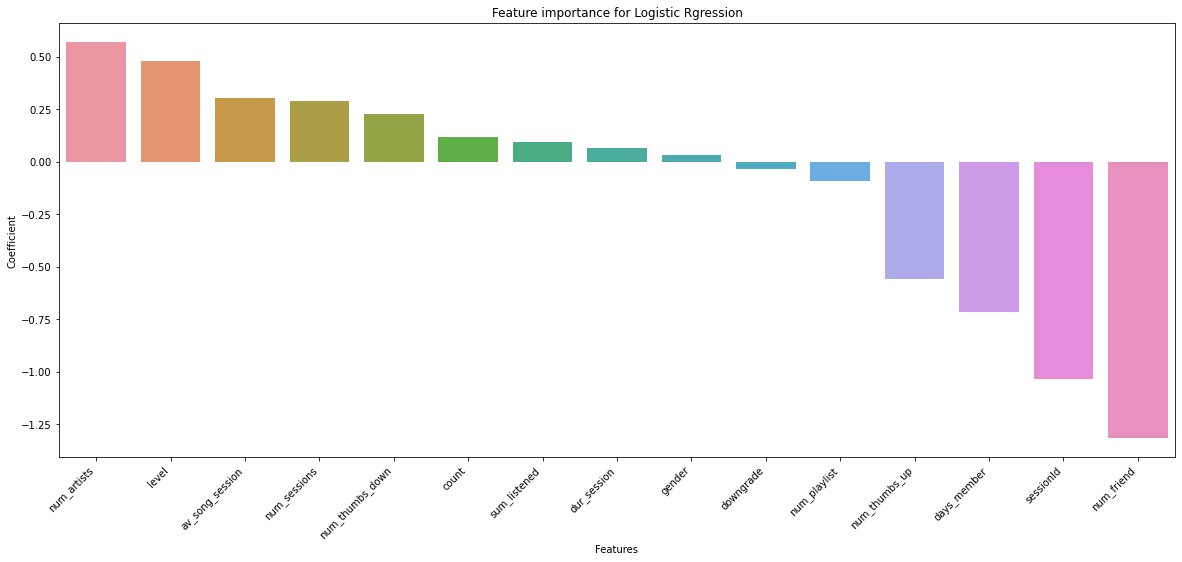

In [74]:
feature_coef = lr_model.coefficients.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
        .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for Logistic Rgression')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
#plt.savefig('')
plt.show()

### Descision Tree

In [62]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features")

In [63]:
dt_model = dt.fit(train)
results_dt = dt_model.transform(test)

get_model_metrics(results_dt)

Accuracy:  0.94
Precision:  0.86
Recall:  0.71
F1-Score:  0.78


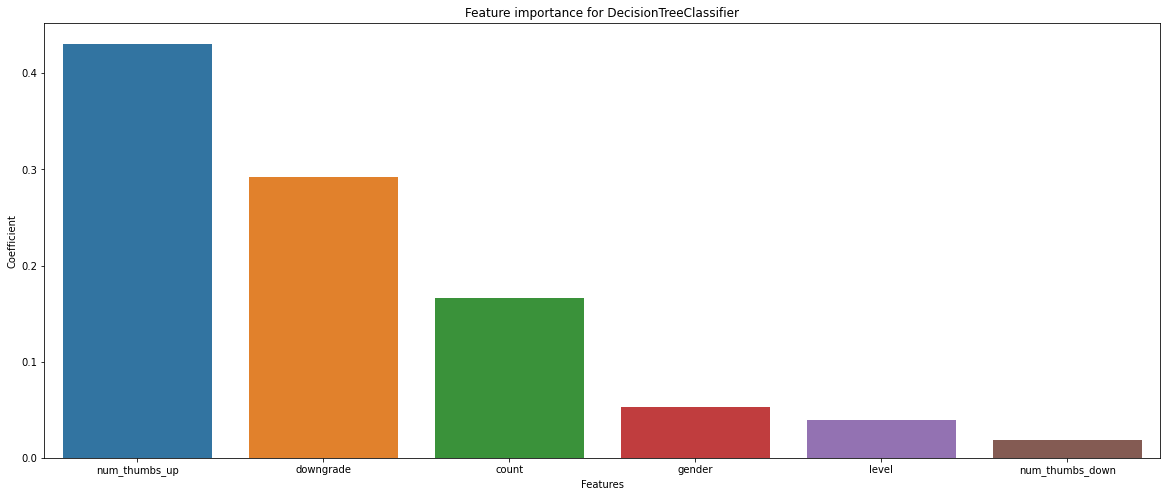

In [76]:
feature_ind = dt_model.featureImportances.indices.tolist()
feature_name = [df_final.columns[1:][ind] for ind in feature_ind]
feature_coef = dt_model.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for DecisionTreeClassifier')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()

### Random Forest

In [65]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features")

In [66]:
rf_model = rf.fit(train)
results_rf = rf_model.transform(test)

get_model_metrics(results_rf)

Accuracy:  0.95
Precision:  1.0
Recall:  0.68
F1-Score:  0.81


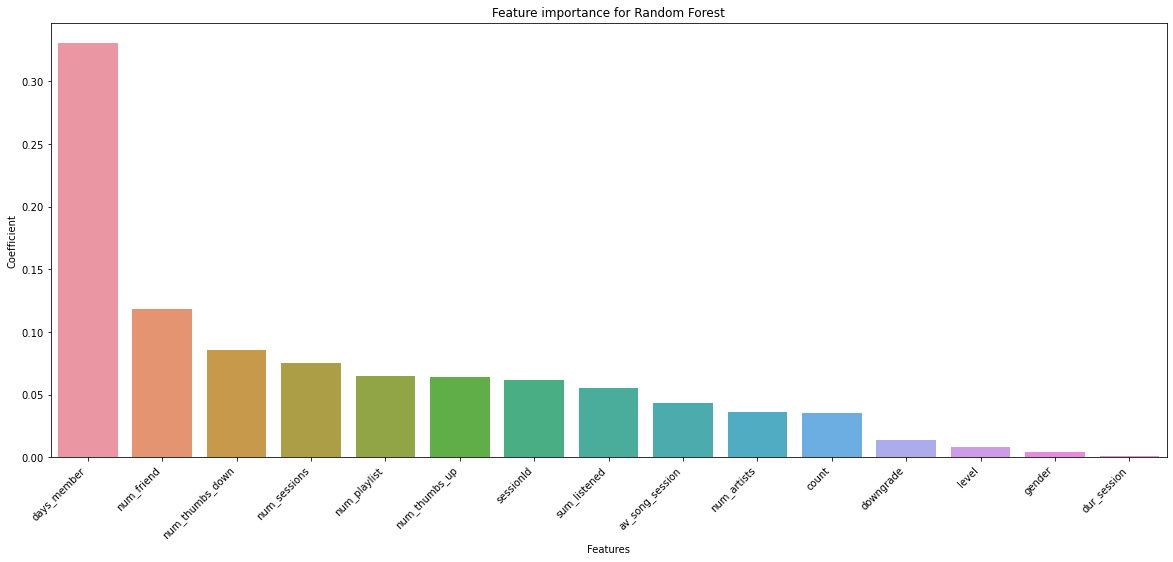

In [77]:
feature_ind = rf_model.featureImportances.indices.tolist()
feature_name = [df_final.columns[1:][ind] for ind in feature_ind]
feature_coef = rf_model.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for Random Forest')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

### GBTClassifier

In [68]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features")

In [69]:
gbt_model = gbt.fit(train)
results_gbt = gbt_model.transform(test)

get_model_metrics(results_gbt)

Accuracy:  0.99
Precision:  1.0
Recall:  0.95
F1-Score:  0.97


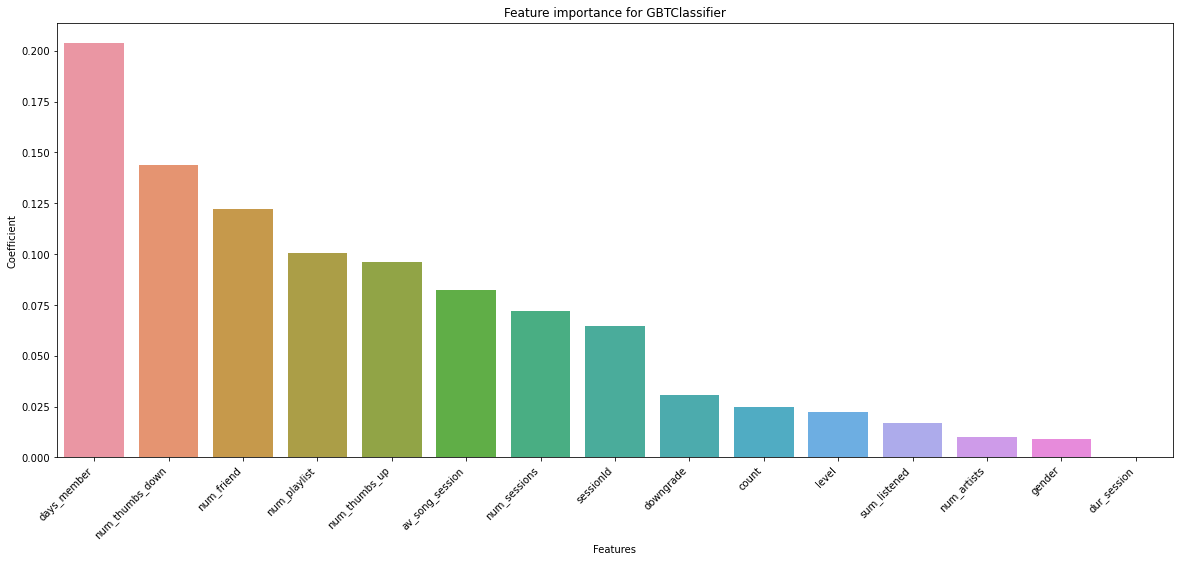

In [79]:
feature_ind = gbt_model.featureImportances.indices.tolist()
feature_name = [df_final.columns[1:][ind] for ind in feature_ind]
feature_coef = gbt_model.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for GBTClassifier')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

# Conclusion

In this notebook, I tested 4 different models to predict customer churn on the given subset of user data. The process therefore consists of three main steps:  

- Data understanding: I removed entries without user_Id and added new functions. In order to improve understanding and to analyze the migration and downgrade of a user, several visualizations were created. After the preparation, 278,154 data records remain in the data record.
- Feature Engineering: I created 15 features for the model and the data format has been brought into the correct form.
- Modeling: For preparing data and I used VectorAssembler and StandardScaler afterwards I splitted 80% of the data in the training set. Since the churned users are a quite small subset, I used the F1-Score as the metric to optimize. I selected four models: Logistic Regression, Decisision Tree Classifier, Random Forest Classifier and GBT Classifier to predict churn.

Without any further optimization the different models showed with the selected 15 features the following performance. 

| Model |Accuracy |	Precision |	Recall 	|F1-Score|
|---:	|----:	|---:	|---:	|---:	|
|Logistic Regression |	0.89| 	0.91 |	0.31 |	0.46|
|Descission Tree |	0.94| 	0.86| 	0.71 |	0.78|
|Random Forest Classifier |	0.95 |	1.0 |	0.68 |	0.81|
|GBT Classifier |	0.99 |	1.0 |	0.95| 	0.97|

The best performance was achieved with a GBT (Gradient Boost Tree) Classifier, with a F1-Score of 0.97 - that is quite impressive. It also showed that the three most critical factors in evaluating a user's churn are the ```time of membership```, the ```number of thumbs down``` as well the ```number of friends```.  

#### Improvements

Even if the F1-Score of the model of 0.97 is very good, the model can be further optimized by more features or another choice of features.  Furthermore, the model could be optimized by model tuning (aka. hyperparameter tuning) such as e.g. cross validation. 

In my opinion, the most important step to improve or at least validate the model is to apply it to the large data set. As the underlaying data set here contains only 278.154 records and 225 unique users.
***

In [80]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Sparkify.ipynb'])

0

Please see also my blog post on [Kaggle](https://www.kaggle.com/chriskue/sparkify-user-churn-prediction).